In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizerrdNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate
from wordcloud import WordCloud 

import warnings; warnings.simplefilter('ignore')

# Simple Recommender

It based on movie popularity and genre.<br />
The movies that are more popular and high voted will have a higher probability of being liked by the most of audience. However, it's not personalized recommendations for user.

In [76]:
mmd = pd.read_csv('Dataset/movies_metadata.csv')

In [77]:
mmd['genres'] = mmd['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

IMDB's weighted rating formula:<br />
Weighted Rating <br />
$$ WR =(\frac{v}{v+m} * R) + (\frac{m}{v+m} * C)$$
v is the # of votes for the movie<br />
m is the minimum votes required to be listed in the chart<br />
R is the average rating of the movie<br />
C is the mean vote across the whole report<br /><br /><br />
We will implement 95th percentile as our cutoff. In other words, the movie which is in the charts, it must have more votes than at least 95% of the movies in the list.

In [151]:
vote_counts = mmd[mmd['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = mmd[mmd['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [152]:
m = vote_counts.quantile(0.95)
m

434.0

In [79]:
mmd['year'] = pd.to_datetime(mmd['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


In [153]:
qualified = mmd[(mmd['vote_count'] >= m) & (mmd['vote_count'].notnull()) & (mmd['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.

In [154]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [155]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [156]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top 15 Movie

In [ ]:
qualified.head(15)

In [159]:
S = mmd.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
S.name = 'genre'
gen_md = mmd.drop('genres', axis=1).join(S)

builds charts for particular genres

In [160]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [161]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.565285
351,Forrest Gump,1994,8147,8,48.3072,7.971357
876,Vertigo,1958,1162,8,18.2082,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.8451,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,7.744878
19901,Paperman,2012,734,8,7.19863,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.9943,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [80]:
#drop the columns we don't need
#mmd.drop(['belongs_to_collection','budget','homepage','imdb_id','runtime','poster_path','production_companies','production_countries','revenue','title','video'], axis=1, inplace=True)

# Content Based Recommender

To personalise our recommendations more, We are going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked.

In [81]:
mmd.count()

adult                    45466
belongs_to_collection     4494
budget                   45466
genres                   45466
homepage                  7782
id                       45466
imdb_id                  45449
original_language        45455
original_title           45466
overview                 44512
popularity               45461
poster_path              45080
production_companies     45463
production_countries     45463
release_date             45379
revenue                  45460
runtime                  45203
spoken_languages         45460
status                   45379
tagline                  20412
title                    45460
video                    45460
vote_average             45460
vote_count               45460
year                     45466
dtype: int64

In [82]:
links_small = pd.read_csv('Dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [83]:
mmd.iloc[35587]

adult                     Avalanche Sharks tells the story of a bikini ...
belongs_to_collection                                             2.185485
budget                                    /zaSf5OG7V8X8gqFvly88zDdRm46.jpg
genres                   [Odyssey Media, Pulser Productions, Rogue Stat...
homepage                          [{'iso_3166_1': 'CA', 'name': 'Canada'}]
id                                                              2014-01-01
imdb_id                                                                  0
original_language                                                     82.0
original_title                    [{'iso_639_1': 'en', 'name': 'English'}]
overview                                                          Released
popularity                                           Beware Of Frost Bites
poster_path                                               Avalanche Sharks
production_companies                                                 False
production_countries     

In [84]:
mmd = mmd.drop([19730, 29503, 35587])

In [85]:
#test if we drop the rows successfully
mmd.count()

adult                    45463
belongs_to_collection     4491
budget                   45463
genres                   45463
homepage                  7779
id                       45463
imdb_id                  45446
original_language        45452
original_title           45463
overview                 44509
popularity               45460
poster_path              45077
production_companies     45460
production_countries     45460
release_date             45376
revenue                  45460
runtime                  45203
spoken_languages         45460
status                   45379
tagline                  20412
title                    45460
video                    45460
vote_average             45460
vote_count               45460
year                     45463
dtype: int64

In [86]:
list(mmd)

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'year']

In [87]:
# check EDA Notebook for how and why we got these indices.
mmd['id'] = mmd['id'].astype('int')


We have 9099 movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset

In [88]:
smd = mmd[mmd['id'].isin(links_small)]
smd.shape


(9099, 25)

### Movie Description Based Recommender

We will use tagline, overview and tagline to do a simple NLP

In [90]:
#use overview and tagline to form a discription
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

use TfidfVectorizer to transforms text to feature vectors that can be used as input to estimator.

In [91]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [92]:
tfidf_matrix.shape

(9099, 268124)

we use Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies.<br />
Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [93]:
# Cosine Similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [94]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [95]:
# Define a function to give the 30 most similar movies to the given one
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [96]:
#run the recommendation function and display the results
get_recommendations('The Godfather')

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [97]:
get_recommendations('The Dark Knight').head()

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
Name: title, dtype: object

In [98]:
get_recommendations('Jumanji').head()

8889                     Pixels
8608    Guardians of the Galaxy
6392                 Stay Alive
8154             Wreck-It Ralph
3196         Dungeons & Dragons
Name: title, dtype: object

### Metadata Based Recommender

We will use cast, crew, genres and credits to build this recommender

In [100]:
credits = pd.read_csv('Dataset/credits.csv')
keywords = pd.read_csv('Dataset/keywords.csv')

In [101]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
mmd['id'] = mmd['id'].astype('int')

In [102]:
mmd.shape

(45463, 25)

merge the metadata with credits and keywords to combine cast, crew, genres and credits, all in one dataframe.

In [104]:
meta_cd = mmd.merge(credits, on='id')
meta_cd_kw = meta_cd.merge(keywords, on='id')

In [105]:
s_meta_cd_kw = meta_cd_kw[meta_cd_kw['id'].isin(links_small)]
s_meta_cd_kw.shape

(9219, 28)

Crew: we only pick the director as our feature since the others don't contribute that much to the feel of the movie.<br />
Cast: Lesser known actors and minor roles do not really affect people's opinion of a movie. <br />
So we only select the major characters and their respective actors. We choose the top 3 actors that appear in the cast column.

In [107]:
s_meta_cd_kw['cast'] = s_meta_cd_kw['cast'].apply(literal_eval)
s_meta_cd_kw['crew'] = s_meta_cd_kw['crew'].apply(literal_eval)
s_meta_cd_kw['keywords'] = s_meta_cd_kw['keywords'].apply(literal_eval)
s_meta_cd_kw['cast_size'] = s_meta_cd_kw['cast'].apply(lambda x: len(x))
s_meta_cd_kw['crew_size'] = s_meta_cd_kw['crew'].apply(lambda x: len(x))

In [108]:
#Define a function to select the directors in crew
def get_director(x):
    
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [109]:
s_meta_cd_kw['director'] = s_meta_cd_kw['crew'].apply(get_director)

In [110]:
s_meta_cd_kw['cast'] = s_meta_cd_kw['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
s_meta_cd_kw['cast'] = s_meta_cd_kw['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [111]:
s_meta_cd_kw['keywords'] = s_meta_cd_kw['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Strip Spaces and Convert to Lowercase from all our features. <br />
Mention Director 3 times to give it more weight relative to the entire cast.

In [113]:
s_meta_cd_kw['cast'] = s_meta_cd_kw['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [114]:
s_meta_cd_kw['director'] = s_meta_cd_kw['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
s_meta_cd_kw['director'] = s_meta_cd_kw['director'].apply(lambda x: [x,x, x])

keywords preprocessing

In [116]:
#calculate the frequenct counts of every keyword that appears in the dataset
s = s_meta_cd_kw.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [117]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [118]:
s = s[s > 1]

In [198]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
#     h = int(360.0 * tone / 255.0)
    h = int(360.0 * float(random_state.randint(0, 180)) / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

(-0.5, 1499.5, 599.5, -0.5)

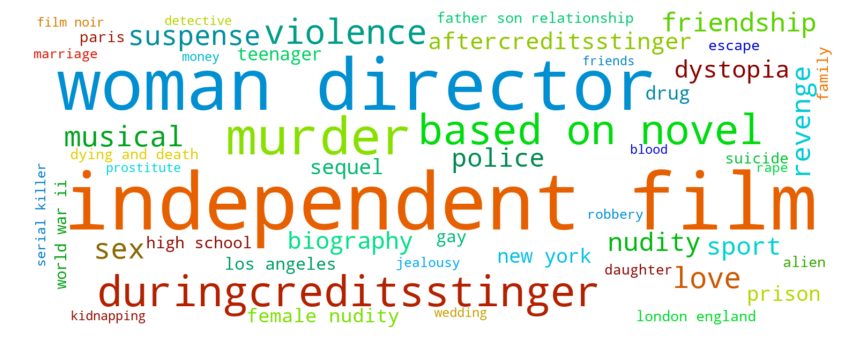

In [234]:
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud


tone = 40.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1500,height=600, background_color='white', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(s[0:50].to_dict())
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')

In [224]:
#convert words to their stems in order that they can be treated as the same.
stemmer = SnowballStemmer('english')
stemmer.stem('cats')

'cat'

In [122]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [123]:
s_meta_cd_kw['keywords'] = s_meta_cd_kw['keywords'].apply(filter_keywords)
s_meta_cd_kw['keywords'] = s_meta_cd_kw['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
s_meta_cd_kw['keywords'] = s_meta_cd_kw['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [124]:
s_meta_cd_kw['soup'] = s_meta_cd_kw['keywords'] + s_meta_cd_kw['cast'] + s_meta_cd_kw['director'] + s_meta_cd_kw['genres']
s_meta_cd_kw['soup'] = s_meta_cd_kw['soup'].apply(lambda x: ' '.join(x))

use a Count Vectorizer to create our count matrix as we did in the Description Recommender

In [125]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(s_meta_cd_kw['soup'])

In [126]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [127]:
s_meta_cd_kw = s_meta_cd_kw.reset_index()
titles = s_meta_cd_kw['original_title']
indices = pd.Series(s_meta_cd_kw.index, index=s_meta_cd_kw['original_title'])

In [128]:
# test the recommadation

In [129]:
get_recommendations('The Dark Knight').head()

8031    The Dark Knight Rises
6218            Batman Begins
6623             The Prestige
2085                Following
7648                Inception
Name: original_title, dtype: object

In [130]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: original_title, dtype: object

In [131]:
# popularity and ratings

In [132]:
m = vote_counts.quantile(0.95)

In [136]:
# top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = s_meta_cd_kw.iloc[movie_indices][['original_title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [162]:
#test the function
improved_recommendations('The Dark Knight')

,original_title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


In [163]:
improved_recommendations('Mean Girls')

,original_title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.709602
390,Dazed and Confused,588,7,1993,6.254682
8883,The DUFF,1372,6,2015,5.818541
3712,The Princess Diaries,1063,6,2001,5.781086
4763,Freaky Friday,919,6,2003,5.757786
6277,Just Like Heaven,595,6,2005,5.681521
6959,The Spiderwick Chronicles,593,6,2008,5.680901
7494,American Pie Presents: The Book of Love,454,5,2009,5.119690
7332,Ghosts of Girlfriends Past,716,5,2009,5.092422
7905,Mr. Popper's Penguins,775,5,2011,5.087912


# Collaborative Filtering

Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

In [164]:
md_lk = pd.read_csv('Dataset/links.csv')
md_lk.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [165]:
md_lk.isnull().sum()

movieId      0
imdbId       0
tmdbId     219
dtype: int64

In [166]:
md_lk.dropna(how='any',inplace=True)

In [167]:
md_lk.tmdbId = md_lk['tmdbId'].astype(int)

In [168]:
md_rt = pd.read_csv('Dataset/ratings_small.csv')
md_rt.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [169]:
md_rt.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [170]:
df_rt = pd.merge(md_rt, md_lk, on='movieId')

In [171]:
df_rt.drop(['timestamp', 'imdbId','movieId'], axis=1, inplace=True)
df_rt.head(5)

,userId,rating,tmdbId
0,1,2.5,9909
1,7,3.0,9909
2,31,4.0,9909
3,32,4.0,9909
4,36,3.0,9909


In [172]:
reader = Reader()

In [173]:
data = Dataset.load_from_df(df_rt[['userId', 'tmdbId', 'rating']], reader)
data.split(n_folds=5)

We use SVD to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [174]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9024
MAE:  0.6913
------------
Fold 2
RMSE: 0.8967
MAE:  0.6929
------------
Fold 3
RMSE: 0.8952
MAE:  0.6886
------------
Fold 4
RMSE: 0.8889
MAE:  0.6862
------------
Fold 5
RMSE: 0.9000
MAE:  0.6909
------------
------------
Mean RMSE: 0.8966
Mean MAE : 0.6900
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9024396793146159,
                             0.8967074877322568,
                             0.8952086207864105,
                             0.8888815016029072,
                             0.9000030735439675],
                            'mae': [0.6912829670064677,
                             0.6928696719452818,
                             0.688620505779237,
                             0.6862324473034656,
                             0.6909150044207697]})

In [175]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [176]:
df_rt[df_rt['userId'] == 1]

,userId,rating,tmdbId
0,1,2.5,9909
42,1,3.0,11360
84,1,3.0,819
117,1,2.0,1103
165,1,4.0,11216
211,1,2.0,11778
259,1,2.0,665
305,1,2.0,783
351,1,3.5,6114
403,1,2.0,1598


In [177]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.5836236333193674, details={'was_impossible': False})

# Hybrid Recommender

In [178]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [180]:
id_map = pd.read_csv('Dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [181]:
indices_map = id_map.set_index('id')

Input: User ID and the Title of a Movie<br />
Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [182]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [183]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
344,True Lies,1138.0,6.8,1994,36955,3.242788
1500,Hamlet,48.0,7.1,1948,23383,2.903985
922,The Bloody Child,0.0,0.0,1996,124676,2.771527
2132,Swamp Thing,92.0,5.4,1982,17918,2.686330
974,Full Metal Jacket,2595.0,7.9,1987,600,2.642847
6084,The Earrings of Madame de...,38.0,7.8,1953,27030,2.642847
831,Pete's Dragon,201.0,6.4,1977,11114,2.642847
7088,A Matter of Loaf and Death,120.0,7.2,2008,14447,2.642847
2761,National Lampoon's Last Resort,8.0,4.6,1994,49338,2.642847
8658,Predestination,1971.0,7.3,2014,206487,2.642847


In [184]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
344,True Lies,1138.0,6.8,1994,36955,3.420908
1500,Hamlet,48.0,7.1,1948,23383,3.064023
974,Full Metal Jacket,2595.0,7.9,1987,600,2.904281
4966,A Woman Under the Influence,87.0,7.8,1974,29845,2.904281
831,Pete's Dragon,201.0,6.4,1977,11114,2.904281
7088,A Matter of Loaf and Death,120.0,7.2,2008,14447,2.904281
2761,National Lampoon's Last Resort,8.0,4.6,1994,49338,2.904281
8658,Predestination,1971.0,7.3,2014,206487,2.904281
4017,Smokey and the Bandit II,87.0,5.1,1980,12705,2.904281
1668,The Man with Two Brains,131.0,6.2,1983,11591,2.904281
